## Data Science Take Home Challenge 1: Relax Challenge

### Author Julia Hu

## Summary of Findings 

### Key solution step 1:

  <li> <b>(1) Load data and process the time series columns for the first csv file</b>: 
  <li> <b>(2) Convert datetime to a readable format

### Key solution step 2:

  <li> <b>(1) Load data and process the time series columns< for the second csv file/b>: 
  <li> <b>(2) Convert datetime to a readable format, and remove the hour, minute and second info
  <li> <b>(3) calculate total number of membership enrollment date
  <li> <b>(4) calculate total number of time visited
  <li> <b>(5) calculate total number of time visited
    
### Key solution step 3: 

 <li> <b>(1) Use rolling window to calculate number of visit within each rolling 7 days. 3D_visit_count
 <li> <b>(2) Define adopted user as who visited 3 times in any 7 days
 <li> <b>(3) Merge the adopted user table with the original user dataframe, and create 'Label' for machine learning
    
### Key solution step 4:

 <li> <b>(1) Further Feature engineering to drop unnecessary features, 
 <li> <b>(2) Time dependant feature engineering: if the id invited any new user or not, total time enrolled in the membership, number of time visited during the membership
 <li> <b>(3) One-hot-encoding for categorical feature

### Key solution step 5:
 <li> <b>(1) Use XGBoost for initial prediction, very high accuracy, 99.6%, AUC score
 <li> <b>(2) Hyperparameter tuning for XGBoost: The final AUC score is 99.68%
 <li> <b>(3) List the feature importance. The importance of features are ranked as: 1. Total number of time visited 2. average visit time interval 3. total amount of time involved in membership, 4. org_id, 5. invite_or_not, 6. opted for email, 7. Membership enrollment method.
 <li> <b>(4) Data exploration: Plotted relationship between adopted and unadopted user with all features. From data exploration, it can be seen that total number of time visited has a positive impact on adopted or not, while average vist time interval has a negative impact on adopted or not.   
    

In [1]:
#****************** This is the solution to the Take Home Challenge 1****************** 
#
#*****************************Jan. 08 2020 ********************************************
#
#**********(1) Load Data into Dataframe and Take care of the time seires columns*******
#**********(2) Convert datetime to a readable suitable format*********************************
#**********(3) Read in the second table for a summary of usage
#**********(4) Use graphvaiz to review which factors play the most important roles in absorbed users*********
#**********(5) Time interval calculation for user_id***************************
#**********(6) Find nearest three acitivity that happen in 7 days*********************

### (1) Load Data into Dataframe and Take care of the time seires columns

In [2]:
#**************first import all necessary libraries**************
import csv
import pandas as pd
import numpy as np
from datetime import datetime
import io
import xgboost as xgb
from tqdm import tqdm
from sklearn.metrics import accuracy_score

In [3]:
user_df = pd.read_csv('takehome_users.csv', encoding='latin-1')
user_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


### (2) Convert datetime to a readable suitable format

In [4]:
#********convert time to a suitable time format*********************
from datetime import datetime
user_df['creation_time'] = pd.to_datetime(user_df['creation_time'],errors='coerce',infer_datetime_format=True)

In [5]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 937.6+ KB


In [6]:
#*************************convert the last_session_creation_time as datetime format**********************
user_df['last_session_creation_time'] = user_df[user_df['last_session_creation_time'].notnull()]['last_session_creation_time'].apply(lambda x:datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

In [7]:
user_df['last_session_creation_time'] = pd.to_datetime(user_df['last_session_creation_time'],errors='coerce',infer_datetime_format=True)

In [8]:
user_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [9]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


### (3) Read in the second table for a summary of usage 

In [10]:
activity_df = pd.read_csv('takehome_user_engagement.csv')
activity_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


### (4) change format of time_stamp as a datetime object

In [11]:
activity_df['time_stamp'] = pd.to_datetime(activity_df['time_stamp'],errors='coerce',infer_datetime_format=True)
activity_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [12]:
activity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


### (5) Start to engineer time features

In [13]:
activity_df['time_stamp_short'] = activity_df['time_stamp'].apply(lambda x:x.strftime("%Y-%m-%d"))
activity_df.sort_values(by='user_id')
activity_df.head()

,time_stamp,user_id,visited,time_stamp_short
0,2014-04-22 03:53:30,1,1,2014-04-22
1,2013-11-15 03:45:04,2,1,2013-11-15
2,2013-11-29 03:45:04,2,1,2013-11-29
3,2013-12-09 03:45:04,2,1,2013-12-09
4,2013-12-25 03:45:04,2,1,2013-12-25


In [14]:
activity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 4 columns):
time_stamp          207917 non-null datetime64[ns]
user_id             207917 non-null int64
visited             207917 non-null int64
time_stamp_short    207917 non-null object
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.3+ MB


In [15]:
activity_df = activity_df.drop('time_stamp',axis=1)

In [16]:
count_df = activity_df.groupby('user_id').agg({'visited':'sum'}).reset_index()
count_df.head()

,user_id,visited
0,1,1
1,2,14
2,3,1
3,4,1
4,5,1


In [17]:
#************link count_df user_id with activity_df, and this gives user_id with number of visit more than 3 times
activity_df = count_df.merge(activity_df,how='left', on='user_id')
activity_df.head()

,user_id,visited_x,visited_y,time_stamp_short
0,1,1,1,2014-04-22
1,2,14,1,2013-11-15
2,2,14,1,2013-11-29
3,2,14,1,2013-12-09
4,2,14,1,2013-12-25


In [18]:
activity_df.rename(columns={'visited_x':'total_visit_number','visited_y':'visit_count'}, inplace=True)
activity_df.head()

,user_id,total_visit_number,visit_count,time_stamp_short
0,1,1,1,2014-04-22
1,2,14,1,2013-11-15
2,2,14,1,2013-11-29
3,2,14,1,2013-12-09
4,2,14,1,2013-12-25


In [19]:
activity_df

,user_id,total_visit_number,visit_count,time_stamp_short
0,1,1,1,2014-04-22
1,2,14,1,2013-11-15
2,2,14,1,2013-11-29
3,2,14,1,2013-12-09
4,2,14,1,2013-12-25
...,...,...,...,...
207912,11996,1,1,2013-09-06
207913,11997,1,1,2013-01-15
207914,11998,1,1,2014-04-27
207915,11999,1,1,2012-06-02


### (6) Find nearest three acitivity that happen in 7 days

In [20]:
activity_df['time_stamp_short']=pd.to_datetime(activity_df['time_stamp_short'],errors='coerce',infer_datetime_format=True)
activity_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207917 entries, 0 to 207916
Data columns (total 4 columns):
user_id               207917 non-null int64
total_visit_number    207917 non-null int64
visit_count           207917 non-null int64
time_stamp_short      207917 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 7.9 MB


In [21]:
def get_rolling_amount(grp, freq):
    return grp.rolling(freq, on='time_stamp_short')['visit_count'].count()

activity_df['3D_visit_count'] = activity_df.groupby('user_id', as_index=False, group_keys=False).apply(get_rolling_amount, '7D')


In [22]:
activity_df

,user_id,total_visit_number,visit_count,time_stamp_short,3D_visit_count
0,1,1,1,2014-04-22,1.0
1,2,14,1,2013-11-15,1.0
2,2,14,1,2013-11-29,1.0
3,2,14,1,2013-12-09,1.0
4,2,14,1,2013-12-25,1.0
...,...,...,...,...,...
207912,11996,1,1,2013-09-06,1.0
207913,11997,1,1,2013-01-15,1.0
207914,11998,1,1,2014-04-27,1.0
207915,11999,1,1,2012-06-02,1.0


#### merge the adopted_df with the user_df, to count into the 3D_visit_count bigger than 3

In [23]:
adopted_df = activity_df[activity_df['3D_visit_count'] >=3.0].drop_duplicates(subset=['user_id','total_visit_number'])

In [24]:
adopted_df

,user_id,total_visit_number,visit_count,time_stamp_short,3D_visit_count
9,2,14,1,2014-02-09,3.0
27,10,284,1,2013-02-19,3.0
312,20,7,1,2014-03-13,3.0
331,33,18,1,2014-03-23,3.0
354,42,342,1,2012-12-26,3.0
...,...,...,...,...,...
207456,11965,8,1,2014-05-02,3.0
207468,11967,43,1,2014-03-10,3.0
207508,11969,131,1,2013-06-03,3.0
207649,11975,216,1,2013-05-29,3.0


### Further Feature engineering to drop unnecessary features, and if the id invited any new user or not, average time to visit

In [25]:
#*********first drop name and email from the merged dataframe
user_df.drop(['name','email'],axis=1, inplace=True)
user_df

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0
...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,ORG_INVITE,2013-09-06 06:14:15,0,0,89,8263.0
11996,11997,2013-01-10 18:28:37,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,0,0,200,NaN
11997,11998,2014-04-27 12:45:16,GUEST_INVITE,2014-04-27 12:45:16,1,1,83,8074.0
11998,11999,2012-05-31 11:55:59,PERSONAL_PROJECTS,2012-06-02 11:55:59,0,0,6,NaN


In [26]:
#*********find out last login time to creation time interval***********
user_df['membership_interval'] = user_df['last_session_creation_time'] - user_df['creation_time']
user_df.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,membership_interval
0,1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0 days
1,2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,136 days
2,3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0 days
3,4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,1 days
4,5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,5 days


In [27]:
#*********create another feature, invitation or not****************
#*****use invited by user_id as a dictionary, if invited, then create a column invited or not.
invite_df = user_df[user_df.object_id.isin(user_df['invited_by_user_id'].fillna(0).astype('int32'))]

In [28]:
invite_df['invite_or_not'] = 1
invite_df.head()

C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,membership_interval,invite_or_not
2,3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0 days,1
6,7,2012-12-16 13:24:32,SIGNUP,2012-12-20 13:24:32,0,1,37,NaN,4 days,1
9,10,2013-01-16 22:08:03,ORG_INVITE,2014-06-03 22:08:03,1,1,318,4143.0,503 days,1
20,21,2013-01-22 12:27:42,PERSONAL_PROJECTS,2013-01-22 12:27:42,0,0,54,NaN,0 days,1
22,23,2012-08-17 08:30:27,ORG_INVITE,2012-08-18 08:30:27,1,0,6,23.0,1 days,1


In [29]:
user_df=user_df.merge(invite_df[['object_id','invite_or_not']], how='left', on='object_id')
user_df.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,membership_interval,invite_or_not
0,1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0 days,NaN
1,2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,136 days,NaN
2,3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0 days,1.0
3,4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,1 days,NaN
4,5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,5 days,NaN


In [30]:
user_df['invite_or_not'].fillna(0, inplace=True)
user_df.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,membership_interval,invite_or_not
0,1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0 days,0.0
1,2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,136 days,0.0
2,3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0 days,1.0
3,4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,1 days,0.0
4,5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,5 days,0.0


In [31]:
user_df = user_df.merge(activity_df[['user_id','total_visit_number']].groupby('user_id').first().reset_index(), how = 'left', left_on = 'object_id', right_on = 'user_id')
user_df.head() 

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,membership_interval,invite_or_not,user_id,total_visit_number
0,1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0 days,0.0,1.0,1.0
1,2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,136 days,0.0,2.0,14.0
2,3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0 days,1.0,3.0,1.0
3,4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,1 days,0.0,4.0,1.0
4,5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,5 days,0.0,5.0,1.0


In [32]:
#*******to find out average days between eacy visit, use (last_login - create) / total_visit_number
user_df['avg_vist_interval'] = (user_df['membership_interval'] / user_df['total_visit_number']).dt.floor('d')

user_df.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,membership_interval,invite_or_not,user_id,total_visit_number,avg_vist_interval
0,1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0 days,0.0,1.0,1.0,0 days
1,2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,136 days,0.0,2.0,14.0,9 days
2,3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0 days,1.0,3.0,1.0,0 days
3,4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,1 days,0.0,4.0,1.0,1 days
4,5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,5 days,0.0,5.0,1.0,5 days


In [33]:
### **********one-hot-encoding for creation_source, and change datetime 64 type to numerical*****
###  ********************************************************************************************
one_hot = pd.get_dummies(user_df['creation_source'])
# Drop column B as it is now encoded
user_df = user_df.drop('creation_source',axis = 1)
# Join the encoded df
user_df = user_df.join(one_hot)
user_df.head()

,object_id,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,membership_interval,invite_or_not,user_id,total_visit_number,avg_vist_interval,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,2014-04-22 03:53:30,1,0,11,10803.0,0 days,0.0,1.0,1.0,0 days,1,0,0,0,0
1,2,2013-11-15 03:45:04,2014-03-31 03:45:04,0,0,1,316.0,136 days,0.0,2.0,14.0,9 days,0,1,0,0,0
2,3,2013-03-19 23:14:52,2013-03-19 23:14:52,0,0,94,1525.0,0 days,1.0,3.0,1.0,0 days,0,1,0,0,0
3,4,2013-05-21 08:09:28,2013-05-22 08:09:28,0,0,1,5151.0,1 days,0.0,4.0,1.0,1 days,1,0,0,0,0
4,5,2013-01-17 10:14:20,2013-01-22 10:14:20,0,0,193,5240.0,5 days,0.0,5.0,1.0,5 days,1,0,0,0,0


In [34]:
adopted_user_df = user_df[user_df.object_id.isin(adopted_df['user_id'])]

In [35]:
adopted_user_df['Label'] = 1
adopted_user_df

C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,object_id,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,membership_interval,invite_or_not,user_id,total_visit_number,avg_vist_interval,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,Label
1,2,2013-11-15 03:45:04,2014-03-31 03:45:04,0,0,1,316.0,136 days,0.0,2.0,14.0,9 days,0,1,0,0,0,1
9,10,2013-01-16 22:08:03,2014-06-03 22:08:03,1,1,318,4143.0,503 days,1.0,10.0,284.0,1 days,0,1,0,0,0,1
19,20,2014-03-06 11:46:38,2014-05-29 11:46:38,0,0,58,NaN,84 days,0.0,20.0,7.0,12 days,0,0,0,1,0,1
32,33,2014-03-11 06:29:09,2014-05-31 06:29:09,0,0,401,79.0,81 days,0.0,33.0,18.0,4 days,1,0,0,0,0,1
41,42,2012-11-11 19:05:07,2014-05-25 19:05:07,1,0,235,NaN,560 days,0.0,42.0,342.0,1 days,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,11965,2014-04-25 07:17:35,2014-05-21 07:17:35,0,0,65,11251.0,26 days,0.0,11965.0,8.0,3 days,1,0,0,0,0,1
11966,11967,2014-01-12 08:12:37,2014-05-31 08:12:37,0,0,15,5688.0,139 days,0.0,11967.0,43.0,3 days,1,0,0,0,0,1
11968,11969,2013-06-01 00:48:14,2014-05-30 00:48:14,1,1,52,6647.0,363 days,0.0,11969.0,131.0,2 days,1,0,0,0,0,1
11974,11975,2013-03-23 11:10:11,2014-05-22 11:10:11,1,0,31,6410.0,425 days,0.0,11975.0,216.0,1 days,1,0,0,0,0,1


In [36]:
no_user_df = user_df[~user_df.object_id.isin(adopted_df['user_id'])]
no_user_df['Label'] = 0
no_user_df

C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,object_id,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,membership_interval,invite_or_not,user_id,total_visit_number,avg_vist_interval,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,Label
0,1,2014-04-22 03:53:30,2014-04-22 03:53:30,1,0,11,10803.0,0 days,0.0,1.0,1.0,0 days,1,0,0,0,0,0
2,3,2013-03-19 23:14:52,2013-03-19 23:14:52,0,0,94,1525.0,0 days,1.0,3.0,1.0,0 days,0,1,0,0,0,0
3,4,2013-05-21 08:09:28,2013-05-22 08:09:28,0,0,1,5151.0,1 days,0.0,4.0,1.0,1 days,1,0,0,0,0,0
4,5,2013-01-17 10:14:20,2013-01-22 10:14:20,0,0,193,5240.0,5 days,0.0,5.0,1.0,5 days,1,0,0,0,0,0
5,6,2013-12-17 03:37:06,2013-12-19 03:37:06,0,0,197,11241.0,2 days,0.0,6.0,1.0,2 days,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,2013-09-06 06:14:15,0,0,89,8263.0,0 days,0.0,11996.0,1.0,0 days,0,1,0,0,0,0
11996,11997,2013-01-10 18:28:37,2013-01-15 18:28:37,0,0,200,NaN,5 days,1.0,11997.0,1.0,5 days,0,0,0,0,1,0
11997,11998,2014-04-27 12:45:16,2014-04-27 12:45:16,1,1,83,8074.0,0 days,0.0,11998.0,1.0,0 days,1,0,0,0,0,0
11998,11999,2012-05-31 11:55:59,2012-06-02 11:55:59,0,0,6,NaN,2 days,1.0,11999.0,1.0,2 days,0,0,1,0,0,0


In [37]:
total_user_df = pd.concat([adopted_user_df,no_user_df],ignore_index=True)
total_user_df

,object_id,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,membership_interval,invite_or_not,user_id,total_visit_number,avg_vist_interval,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,Label
0,2,2013-11-15 03:45:04,2014-03-31 03:45:04,0,0,1,316.0,136 days,0.0,2.0,14.0,9 days,0,1,0,0,0,1
1,10,2013-01-16 22:08:03,2014-06-03 22:08:03,1,1,318,4143.0,503 days,1.0,10.0,284.0,1 days,0,1,0,0,0,1
2,20,2014-03-06 11:46:38,2014-05-29 11:46:38,0,0,58,NaN,84 days,0.0,20.0,7.0,12 days,0,0,0,1,0,1
3,33,2014-03-11 06:29:09,2014-05-31 06:29:09,0,0,401,79.0,81 days,0.0,33.0,18.0,4 days,1,0,0,0,0,1
4,42,2012-11-11 19:05:07,2014-05-25 19:05:07,1,0,235,NaN,560 days,0.0,42.0,342.0,1 days,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,2013-09-06 06:14:15,0,0,89,8263.0,0 days,0.0,11996.0,1.0,0 days,0,1,0,0,0,0
11996,11997,2013-01-10 18:28:37,2013-01-15 18:28:37,0,0,200,NaN,5 days,1.0,11997.0,1.0,5 days,0,0,0,0,1,0
11997,11998,2014-04-27 12:45:16,2014-04-27 12:45:16,1,1,83,8074.0,0 days,0.0,11998.0,1.0,0 days,1,0,0,0,0,0
11998,11999,2012-05-31 11:55:59,2012-06-02 11:55:59,0,0,6,NaN,2 days,1.0,11999.0,1.0,2 days,0,0,1,0,0,0


### Train test split, then run XGBoost to rank the feature importance

In [38]:
#***********drop unnecessary columns***************
total_user_df.drop(['creation_time','object_id','last_session_creation_time','invited_by_user_id','user_id'],axis=1,inplace=True)
total_user_df.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,membership_interval,invite_or_not,total_visit_number,avg_vist_interval,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,Label
0,0,0,1,136 days,0.0,14.0,9 days,0,1,0,0,0,1
1,1,1,318,503 days,1.0,284.0,1 days,0,1,0,0,0,1
2,0,0,58,84 days,0.0,7.0,12 days,0,0,0,1,0,1
3,0,0,401,81 days,0.0,18.0,4 days,1,0,0,0,0,1
4,1,0,235,560 days,0.0,342.0,1 days,0,0,0,1,0,1


In [39]:
total_user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 13 columns):
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
membership_interval           8823 non-null timedelta64[ns]
invite_or_not                 12000 non-null float64
total_visit_number            8823 non-null float64
avg_vist_interval             8823 non-null timedelta64[ns]
GUEST_INVITE                  12000 non-null uint8
ORG_INVITE                    12000 non-null uint8
PERSONAL_PROJECTS             12000 non-null uint8
SIGNUP                        12000 non-null uint8
SIGNUP_GOOGLE_AUTH            12000 non-null uint8
Label                         12000 non-null int64
dtypes: float64(2), int64(4), timedelta64[ns](2), uint8(5)
memory usage: 808.7 KB


In [45]:
###Convert timedelta dataformat to float
total_user_df['membership_interval'] = total_user_df['membership_interval'].dt.days 
total_user_df['avg_vist_interval'] = total_user_df['avg_vist_interval'].dt.days
total_user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 13 columns):
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
membership_interval           8823 non-null float64
invite_or_not                 12000 non-null float64
total_visit_number            8823 non-null float64
avg_vist_interval             8823 non-null float64
GUEST_INVITE                  12000 non-null uint8
ORG_INVITE                    12000 non-null uint8
PERSONAL_PROJECTS             12000 non-null uint8
SIGNUP                        12000 non-null uint8
SIGNUP_GOOGLE_AUTH            12000 non-null uint8
Label                         12000 non-null int64
dtypes: float64(4), int64(4), uint8(5)
memory usage: 808.7 KB


In [46]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(total_user_df.iloc[:,:-1], total_user_df['Label'], test_size=0.25, random_state=21)

In [47]:
train_x.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,membership_interval,invite_or_not,total_visit_number,avg_vist_interval,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
1729,0,0,1,0.0,1.0,1.0,0.0,0,1,0,0,0
9827,1,1,288,2.0,0.0,1.0,2.0,0,0,0,0,1
8600,0,0,45,29.0,0.0,2.0,14.0,0,1,0,0,0
11085,1,1,294,1.0,0.0,1.0,1.0,1,0,0,0,0
9531,0,0,0,NaN,1.0,NaN,NaN,0,1,0,0,0


In [48]:
train_y.value_counts()

0    7826
1    1174
Name: Label, dtype: int64

In [49]:
dtrain = xgb.DMatrix(train_x, label=train_y, missing = np.NAN)

C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [50]:
params = {"objective": "binary:logistic", 
          #"booster" : "gbtree", 
          "eta": 0.05, 
          "max_depth": 6, 
          "subsample": 0.6, 
          "colsample_bytree": 0.7,
          #"silent": 1, 
          "seed": 1234, 
          "eval_metric": "auc",
          "min_child_weight": 5,
          "gamma": 0} 

In [51]:
cv_results = xgb.cv(params, dtrain,
                    num_boost_round=1000,
                    nfold=5,
                    maximize=True, 
                    stratified=True,
                    shuffle=True,
                    verbose_eval=50,
                    seed=1234,
                    early_stopping_rounds=50)

[0]	train-auc:0.996397+0.000494654	test-auc:0.995866+0.0025313
[50]	train-auc:0.999072+4.61848e-05	test-auc:0.998645+0.000261446
[100]	train-auc:0.999248+5.3057e-05	test-auc:0.9987+0.000224406
[150]	train-auc:0.999313+4.6675e-05	test-auc:0.998701+0.000280034


In [ ]:
best_score = cv_results['test-auc-mean'].max()
best_iteration = len(cv_results)
print('best score:', best_score, 'best iterations:', best_iteration)

In [58]:
%%time
scores = []
for max_depth in [2,3, 4, 5, 6, 7, 8, 9,10]:

    params['max_depth'] = max_depth
    cv_results = xgb.cv(params, dtrain,
                    num_boost_round=1000,
                    nfold=5,
                    maximize=True, 
                    stratified=True,
                    shuffle=True,
                    verbose_eval=200,
                    seed=1234,
                    early_stopping_rounds=50)

    
    best_score = cv_results['test-auc-mean'].max()
    best_iteration = len(cv_results)           
    print(max_depth, best_score, best_iteration)
    scores.append([best_score, params['eta'], params['max_depth'], params['min_child_weight'],
                   params['colsample_bytree'], params['subsample'], params['gamma'], best_iteration])

scores = pd.DataFrame(scores, columns=['score', 'eta', 'max_depth', 'min_child_weight',
                                       'colsample_bytree', 'subsample', 'gamma', 'best_iteration'])
best_max_depth = scores.sort_values(by='score', ascending=False)['max_depth'].values[0]
print('Best max_depth is', best_max_depth)    

[0]	train-auc:0.992457+0.00236887	test-auc:0.991181+0.00424308
[200]	train-auc:0.999071+6.1709e-05	test-auc:0.998734+0.000264161
2 0.9987458 212
[0]	train-auc:0.996247+0.000514875	test-auc:0.995637+0.00243943
3 0.9987266 115
[0]	train-auc:0.996382+0.000488058	test-auc:0.99587+0.00251285
4 0.9987388000000001 119
[0]	train-auc:0.996397+0.000494654	test-auc:0.995866+0.0025313
5 0.9987467999999999 114
[0]	train-auc:0.996397+0.000494654	test-auc:0.995866+0.0025313
6 0.9987304 113
[0]	train-auc:0.996397+0.000494654	test-auc:0.995866+0.0025313
7 0.998727 114
[0]	train-auc:0.996397+0.000494654	test-auc:0.995866+0.0025313
8 0.9987277999999999 118
[0]	train-auc:0.996397+0.000494654	test-auc:0.995866+0.0025313
9 0.9987234 121
[0]	train-auc:0.996397+0.000494654	test-auc:0.995866+0.0025313
10 0.9987324000000001 115
Best max_depth is 5
Wall time: 37.4 s


In [ ]:
%%time
scores = []
for min_child_weight in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:

    params['max_depth'] = best_max_depth
    params['min_child_weight'] = min_child_weight
    cv_results = xgb.cv(params, dtrain,
                    num_boost_round=1000,
                    nfold=5,
                    maximize=True, 
                    stratified=True,
                    shuffle=True,
                    verbose_eval=200,
                    seed=1234,
                    early_stopping_rounds=50)

    
    best_score = cv_results['test-auc-mean'].max()
    best_iteration = len(cv_results)           
    print(min_child_weight, best_score, best_iteration)
    scores.append([best_score, params['eta'], params['max_depth'], params['min_child_weight'],
                   params['colsample_bytree'], params['subsample'], params['gamma'], best_iteration])

scores = pd.DataFrame(scores, columns=['score', 'eta', 'max_depth', 'min_child_weight',
                                       'colsample_bytree', 'subsample', 'gamma', 'best_iteration'])
best_min_child_weight = scores.sort_values(by='score', ascending=False)['min_child_weight'].values[0]
print('Best min_child_weight is', best_min_child_weight)    

In [60]:
%%time
scores = []
for colsample_bytree in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:

    params['max_depth'] = best_max_depth
    params['min_child_weight'] = best_min_child_weight
    params['colsample_bytree'] = colsample_bytree
    cv_results = xgb.cv(params, dtrain,
                    num_boost_round=1000,
                    nfold=5,
                    maximize=True, 
                    stratified=True,
                    shuffle=True,
                    verbose_eval=200,
                    seed=1234,
                    early_stopping_rounds=50)

    
    best_score = cv_results['test-auc-mean'].max()
    best_iteration = len(cv_results)           
    print(colsample_bytree, best_score, best_iteration)
    scores.append([best_score, params['eta'], params['max_depth'], params['min_child_weight'],
                   params['colsample_bytree'], params['subsample'], params['gamma'], best_iteration])

scores = pd.DataFrame(scores, columns=['score', 'eta', 'max_depth', 'min_child_weight',
                                       'colsample_bytree', 'subsample', 'gamma', 'best_iteration'])
best_colsample_bytree = scores.sort_values(by='score', ascending=False)['colsample_bytree'].values[0]
print('Best colsample_bytree is', best_colsample_bytree)    

[0]	train-auc:0.535531+0.00330258	test-auc:0.535518+0.0132121
[200]	train-auc:0.998118+0.000104501	test-auc:0.997406+0.000801814
[400]	train-auc:0.998815+0.000104013	test-auc:0.997987+0.000546703
[600]	train-auc:0.99917+5.1624e-05	test-auc:0.998169+0.000495766
[800]	train-auc:0.999363+5.39503e-05	test-auc:0.998295+0.00045828
0.1 0.9983989999999998 947
[0]	train-auc:0.873192+0.00322213	test-auc:0.869245+0.00925508
[200]	train-auc:0.999111+4.2608e-05	test-auc:0.998271+0.000498882
[400]	train-auc:0.999575+5.69407e-05	test-auc:0.998602+0.000334487
[600]	train-auc:0.999753+2.95878e-05	test-auc:0.998691+0.000293541
0.2 0.9986998 642
[0]	train-auc:0.873184+0.00322864	test-auc:0.869014+0.00893207
[200]	train-auc:0.999477+6.31411e-05	test-auc:0.998598+0.000327145
[400]	train-auc:0.9998+4.22876e-05	test-auc:0.998738+0.000288826
0.3 0.9987472000000001 431
[0]	train-auc:0.878441+0.00448435	test-auc:0.868708+0.00515614
[200]	train-auc:0.999637+4.31713e-05	test-auc:0.998713+0.000278348
[400]	train-a

In [61]:
%%time
scores = []
for subsample in [0.1, 0.2,0.3,0.4, 0.5,0.6, 0.7,0.8, 0.9]:

    params['max_depth'] = best_max_depth
    params['min_child_weight'] = best_min_child_weight
    params['colsample_bytree'] = best_colsample_bytree
    params['subsample'] = subsample 
    cv_results = xgb.cv(params, dtrain,
                    num_boost_round=1000,
                    nfold=5,
                    maximize=True, 
                    stratified=True,
                    shuffle=True,
                    verbose_eval=200,
                    seed=1234,
                    early_stopping_rounds=50)

    
    best_score = cv_results['test-auc-mean'].max()
    best_iteration = len(cv_results)           
    print(subsample, best_score, best_iteration)
    scores.append([best_score, params['eta'], params['max_depth'], params['min_child_weight'],
                   params['colsample_bytree'], params['subsample'], params['gamma'], best_iteration])

scores = pd.DataFrame(scores, columns=['score', 'eta', 'max_depth', 'min_child_weight',
                                       'colsample_bytree', 'subsample', 'gamma', 'best_iteration'])
best_subsample = scores.sort_values(by='score', ascending=False)['subsample'].values[0]
print('Best subsample is', best_subsample)   

[0]	train-auc:0.989744+0.00529627	test-auc:0.990713+0.00536026
0.1 0.9987266 151
[0]	train-auc:0.990704+0.00523539	test-auc:0.991474+0.00527554
0.2 0.998723 74
[0]	train-auc:0.992549+0.00329063	test-auc:0.992023+0.00477368
0.3 0.998788 137
[0]	train-auc:0.995621+0.00236195	test-auc:0.99479+0.0047821
0.4 0.9987988 47
[0]	train-auc:0.995099+0.00238245	test-auc:0.993979+0.00531479
0.5 0.9988582000000001 117
[0]	train-auc:0.996567+0.000507547	test-auc:0.995703+0.00257011
0.6 0.9988816 124
[0]	train-auc:0.996723+0.000500041	test-auc:0.99635+0.00208576
[200]	train-auc:0.999859+2.97684e-05	test-auc:0.998875+0.000256119
0.7 0.9988975999999999 169
[0]	train-auc:0.996777+0.000525277	test-auc:0.99634+0.0020591
0.8 0.9989018 113
[0]	train-auc:0.996879+0.000578655	test-auc:0.996449+0.00196855
0.9 0.998912 122
Best subsample is 0.9
Wall time: 37.2 s


In [62]:
 %%time
scores = []
for gamma in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,0.8,0.9,1]:

    params['max_depth'] = best_max_depth
    params['min_child_weight'] = best_min_child_weight
    params['colsample_bytree'] = best_colsample_bytree
    params['subsample'] = best_subsample 
    params['gamma'] = gamma
    cv_results = xgb.cv(params, dtrain,
                    num_boost_round=1500,
                    nfold=5,
                    maximize=True, 
                    stratified=True,
                    shuffle=True,
                    verbose_eval=200,
                    seed=1234,
                    early_stopping_rounds=50)

    
    best_score = cv_results['test-auc-mean'].max()
    best_iteration = len(cv_results)           
    print(gamma, best_score, best_iteration)
    scores.append([best_score, params['eta'], params['max_depth'], params['min_child_weight'],
                   params['colsample_bytree'], params['subsample'], params['gamma'], best_iteration])

scores = pd.DataFrame(scores, columns=['score', 'eta', 'max_depth', 'min_child_weight',
                                       'colsample_bytree', 'subsample', 'gamma', 'best_iteration'])
best_gamma = scores.sort_values(by='score', ascending=False)['gamma'].values[0]
print('Best gamma is', best_gamma)    

[0]	train-auc:0.996879+0.000578655	test-auc:0.996449+0.00196855
0 0.998912 122
[0]	train-auc:0.996877+0.000580966	test-auc:0.996449+0.00196855
[200]	train-auc:0.999869+3.4273e-05	test-auc:0.998907+0.00025078
0.1 0.9989136000000001 168
[0]	train-auc:0.996875+0.000581839	test-auc:0.996443+0.00197053
0.2 0.998915 119
[0]	train-auc:0.996875+0.000581839	test-auc:0.996443+0.00197053
0.3 0.998916 124
[0]	train-auc:0.996873+0.000583632	test-auc:0.996433+0.00195737
[200]	train-auc:0.999859+3.3415e-05	test-auc:0.998898+0.000243932
0.4 0.9989198 162
[0]	train-auc:0.996871+0.000584824	test-auc:0.996427+0.00195335
0.5 0.9989152000000001 121
[0]	train-auc:0.996871+0.000584824	test-auc:0.996427+0.00195335
0.6 0.9989158 145
[0]	train-auc:0.996867+0.000587986	test-auc:0.99642+0.00195567
0.7 0.9989025999999999 122
[0]	train-auc:0.996854+0.00058863	test-auc:0.996403+0.00192403
0.8 0.9989047999999998 127
[0]	train-auc:0.996854+0.00058863	test-auc:0.996403+0.00192403
0.9 0.9989044 122
[0]	train-auc:0.99685

In [63]:
print(best_max_depth, best_min_child_weight,
      best_colsample_bytree, best_subsample, best_gamma)

scores.sort_values(by='score',ascending=False)

5 1 0.8 0.9 0.4


,score,eta,max_depth,min_child_weight,colsample_bytree,subsample,gamma,best_iteration
4,0.998920,0.05,5,1,0.8,0.9,0.4,162
3,0.998916,0.05,5,1,0.8,0.9,0.3,124
6,0.998916,0.05,5,1,0.8,0.9,0.6,145
5,0.998915,0.05,5,1,0.8,0.9,0.5,121
2,0.998915,0.05,5,1,0.8,0.9,0.2,119
1,0.998914,0.05,5,1,0.8,0.9,0.1,168
0,0.998912,0.05,5,1,0.8,0.9,0.0,122
10,0.998911,0.05,5,1,0.8,0.9,1.0,131
8,0.998905,0.05,5,1,0.8,0.9,0.8,127
9,0.998904,0.05,5,1,0.8,0.9,0.9,122


In [64]:
%%time
scores = []
for eta in [0.1, 0.05, 0.01, .005]:

    params['max_depth'] = best_max_depth
    params['min_child_weight'] = best_min_child_weight
    params['colsample_bytree'] = best_colsample_bytree
    params['subsample'] = best_subsample 
    params['gamma'] = best_gamma
    params['eta'] = eta
    cv_results = xgb.cv(params, dtrain,
                    num_boost_round=1500,
                    nfold=5,
                    maximize=True, 
                    stratified=True,
                    shuffle=True,
                    verbose_eval=200,
                    seed=1234,
                    early_stopping_rounds=50)

    
    best_score = cv_results['test-auc-mean'].max()
    best_iteration = len(cv_results)           
    print(eta, best_score, best_iteration)
    scores.append([best_score, params['eta'], params['max_depth'], params['min_child_weight'],
                   params['colsample_bytree'], params['subsample'], params['gamma'], best_iteration])

scores = pd.DataFrame(scores, columns=['score', 'eta', 'max_depth', 'min_child_weight',
                                       'colsample_bytree', 'subsample', 'gamma', 'best_iteration'])
best_eta = scores.sort_values(by='score', ascending=False)['eta'].values[0]
print('Best eta is', best_eta)    

[0]	train-auc:0.996873+0.000583632	test-auc:0.996433+0.00195737
0.1 0.9989511999999999 60
[0]	train-auc:0.996873+0.000583632	test-auc:0.996433+0.00195737
[200]	train-auc:0.999859+3.3415e-05	test-auc:0.998898+0.000243932
0.05 0.9989198 162
[0]	train-auc:0.996873+0.000583632	test-auc:0.996433+0.00195737
[200]	train-auc:0.999465+1.3644e-05	test-auc:0.998758+0.000261562
[400]	train-auc:0.999618+3.2554e-05	test-auc:0.998883+0.000212408
0.01 0.9989080000000001 484
[0]	train-auc:0.996873+0.000583632	test-auc:0.996433+0.00195737
[200]	train-auc:0.998993+0.000202245	test-auc:0.998109+0.000750689
0.005 0.9983688 279
Best eta is 0.1
Wall time: 29.1 s


In [65]:
params['eta'] = best_eta
params['max_depth'] = best_max_depth
params['min_child_weight'] = best_min_child_weight
params['colsample_bytree'] = best_colsample_bytree
params['subsample'] = best_subsample 
params['gamma'] = best_gamma
cv_results = xgb.cv(params, dtrain,
                num_boost_round=1500,
                nfold=5,
                maximize=True, 
                stratified=True,
                shuffle=True,
                verbose_eval=200,
                seed=1234,
                early_stopping_rounds=50)

best_score = cv_results['test-auc-mean'].max()
best_iteration = len(cv_results)           
print(best_score, best_iteration)

[0]	train-auc:0.996873+0.000583632	test-auc:0.996433+0.00195737
0.9989511999999999 60


# Feature Importance Exploration and experiment with removing not important features

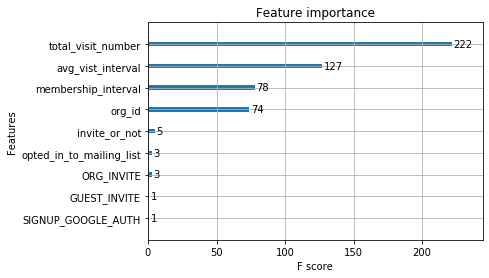

In [67]:
import xgboost as xgb
import matplotlib.pylab as plt
from matplotlib import pyplot
from xgboost import plot_importance
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=21)
xgb_model.fit(train_x, train_y)
plot_importance(xgb_model, max_num_features=20) # top 20 most important features
plt.show()

# Last step, plot out relationship between total_visit_number for adopted/unadopted, average_vist_interval for adopted and unadopted, membership_interval, and org_id.

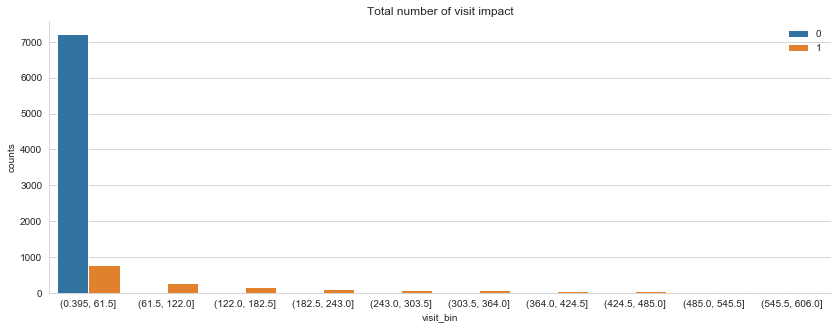

In [74]:
import seaborn as sns
#Plot the relationship between features and label
total_user_df['visit_bin'] = pd.cut(total_user_df['total_visit_number'], bins=10)
visit_df=total_user_df[['visit_bin','Label','SIGNUP_GOOGLE_AUTH']].groupby(['Label','visit_bin'])['SIGNUP_GOOGLE_AUTH'].count().reset_index()

plt.figure(figsize=(14, 5))
ax = sns.barplot( x = 'visit_bin', y = 'SIGNUP_GOOGLE_AUTH', hue='Label',data=visit_df)
ax.set_title('Total number of visit impact')
ax.legend(loc='upper right', frameon=False)
ax.set_ylabel('counts')
sns.set_style('whitegrid')
sns.despine()
plt.show()

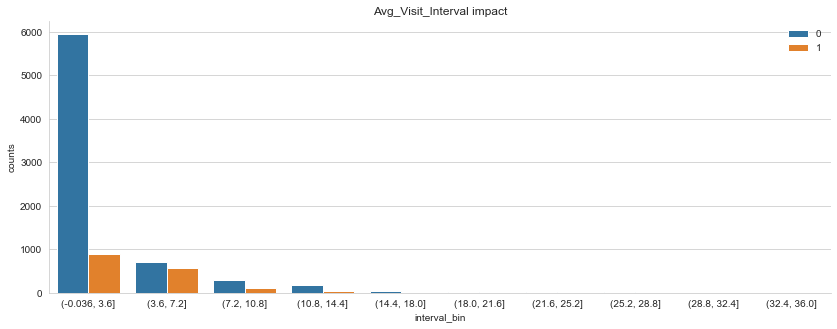

In [75]:
#Plot the relationship between features and label
total_user_df['interval_bin'] = pd.cut(total_user_df['avg_vist_interval'], bins=10)
visit_df=total_user_df[['interval_bin','Label','SIGNUP_GOOGLE_AUTH']].groupby(['Label','interval_bin'])['SIGNUP_GOOGLE_AUTH'].count().reset_index()

plt.figure(figsize=(14, 5))
ax = sns.barplot( x = 'interval_bin', y = 'SIGNUP_GOOGLE_AUTH', hue='Label',data=visit_df)
ax.set_title('Avg_Visit_Interval impact')
ax.legend(loc='upper right', frameon=False)
ax.set_ylabel('counts')
sns.set_style('whitegrid')
sns.despine()
plt.show()


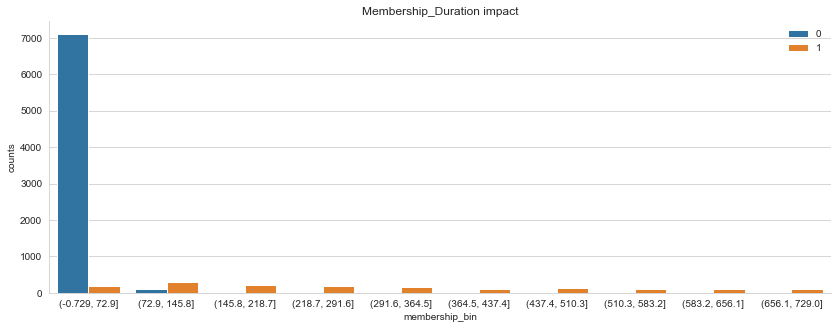

In [76]:
import seaborn as sns
#Plot the relationship between features and label
total_user_df['membership_bin'] = pd.cut(total_user_df['membership_interval'], bins=10)
visit_df=total_user_df[['membership_bin','Label','SIGNUP_GOOGLE_AUTH']].groupby(['Label','membership_bin'])['SIGNUP_GOOGLE_AUTH'].count().reset_index()

plt.figure(figsize=(14, 5))
ax = sns.barplot( x = 'membership_bin', y = 'SIGNUP_GOOGLE_AUTH', hue='Label',data=visit_df)
ax.set_title('Membership_Duration impact')
ax.legend(loc='upper right', frameon=False)
ax.set_ylabel('counts')
sns.set_style('whitegrid')
sns.despine()
plt.show()

In [79]:
org_df = total_user_df[['org_id','Label','SIGNUP_GOOGLE_AUTH']].groupby(['org_id','Label'])['SIGNUP_GOOGLE_AUTH'].count()
org_df = org_df.unstack(level=0).reset_index()


In [80]:
org_df

org_id,Label,0,1,2,3,4,5,6,7,8,...,407,408,409,410,411,412,413,414,415,416
0,0,308.0,219.0,186.0,154.0,143.0,116.0,127.0,103.0,87.0,...,10.0,15.0,15.0,12.0,23.0,17.0,13.0,18.0,10.0,2.0
1,1,11.0,14.0,15.0,14.0,16.0,12.0,11.0,16.0,10.0,...,2.0,3.0,2.0,1.0,3.0,NaN,3.0,2.0,6.0,NaN


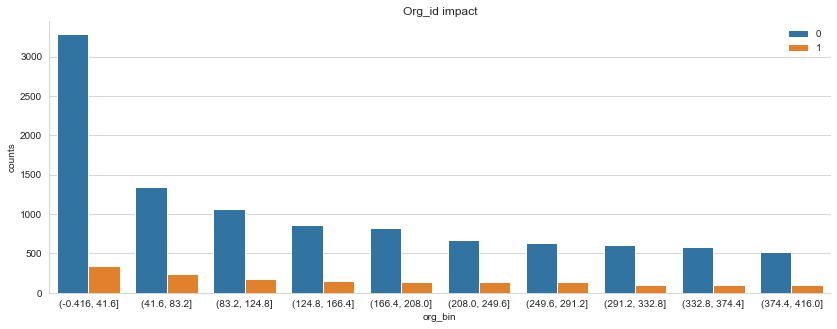

In [82]:
#Plot the relationship between features and label
total_user_df['org_bin'] = pd.cut(total_user_df['org_id'], bins=10)
org_df=total_user_df[['org_bin','Label','SIGNUP_GOOGLE_AUTH']].groupby(['Label','org_bin'])['SIGNUP_GOOGLE_AUTH'].count().reset_index()

plt.figure(figsize=(14, 5))
ax = sns.barplot( x = 'org_bin', y = 'SIGNUP_GOOGLE_AUTH', hue='Label',data=org_df)
ax.set_title('Org_id impact')
ax.legend(loc='upper right', frameon=False)
ax.set_ylabel('counts')
sns.set_style('whitegrid')
sns.despine()
plt.show()

In [85]:
invite_df = total_user_df[['Label','invite_or_not','SIGNUP_GOOGLE_AUTH']].groupby(['Label','invite_or_not'])['SIGNUP_GOOGLE_AUTH'].count()

invite_df = invite_df.unstack(level=0).reset_index()
invite_df

Label,invite_or_not,0,1
0,0.0,8262,1174
1,1.0,2136,428


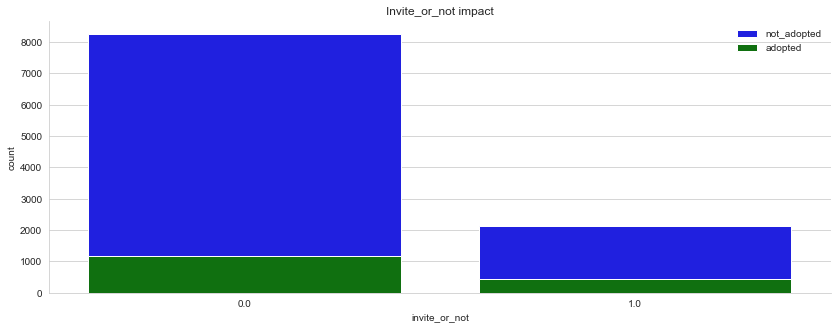

In [91]:
plt.figure(figsize=(14, 5))
ax = sns.barplot(x='invite_or_not', y=0.0,data = invite_df, color='blue',label='not_adopted' )
ax = sns.barplot(x='invite_or_not',y = 1.0,data=invite_df, color='green',label='adopted' )


ax.set_xlabel('invite_or_not')
ax.set_ylabel('count')
ax.set_title('Invite_or_not impact')
ax.legend(loc='upper right',frameon = False)

sns.set_style('whitegrid')

sns.despine()

plt.show()